# DevUp: Divvy Bikes - Part 2
### By Mackenzie Bogiages

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
# import data and concatenate ride dataframes
df_q1_2017 = pd.read_csv("Divvy_Trips_2017_Q1.csv")
df_q2_2017 = pd.read_csv("Divvy_Trips_2017_Q2.csv")
df_q3_2017 = pd.read_csv("Divvy_Trips_2017_Q3.csv")
df_q4_2017 = pd.read_csv("Divvy_Trips_2017_Q4.csv")
df_station_q1q2 = pd.read_csv("Divvy_Stations_2017_Q1Q2.csv")
df_station_q3q4 = pd.read_csv("Divvy_Stations_2017_Q3Q4.csv")

df_2017 = pd.concat([df_q1_2017, df_q2_2017, df_q3_2017, df_q4_2017])
df_2017.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0


In [3]:
# concatenate to and from station names
df_station = pd.concat([df_station_q1q2, df_station_q3q4])
df_station = df_station.drop_duplicates()
df_from_station = pd.concat([df_station_q1q2,df_station_q3q4])
df_to_station = pd.concat([df_station_q1q2,df_station_q3q4])
# rename columns
df_from_station = df_from_station.rename(columns={"id": "from_station_id", "latitude": "from_lat", "longitude": "from_long"})
df_to_station = df_to_station.rename(columns={"id": "to_station_id", "latitude": "to_lat", "longitude": "to_long"})
# drop unused columns
df_from_station = df_from_station.drop(['Unnamed: 7', 'city', 'dpcapacity', 'name', 'online_date'], axis=1)
df_to_station = df_to_station.drop(['Unnamed: 7', 'city', 'dpcapacity', 'name', 'online_date'], axis=1)
# drop duplicates
df_from_station = df_from_station.drop_duplicates(subset='from_station_id', keep="last")
df_to_station = df_to_station.drop_duplicates(subset='to_station_id', keep="last")
df_to_station.shape

/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.



(585, 3)

In [4]:
# drop duplicates
df_2017 = df_2017.drop_duplicates()
# merge with from coordinates
df_2017 = df_2017.merge(df_from_station)
# merge with to coordinates
df_2017 = df_2017.merge(df_to_station)
df_2017.head()
df_2017.shape

(3829003, 16)

In [5]:
df_2017.shape

(3829003, 16)

In [6]:
# calculate distance from Haversine formula
def haversine_np(from_long, from_lat, to_long, to_lat):
    from_long, from_lat, to_long, to_lat = map(np.radians, [from_long, from_lat, to_long, to_lat])
    dlon = to_long - from_long
    dlat = to_lat - from_lat
    a = np.sin(dlat / 2.0)**2 + np.cos(from_lat) * np.cos(to_lat) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956 * c
    return r

In [7]:
# create new column for distance (miles)
df_2017['distance'] = haversine_np(df_2017['from_long'], df_2017['from_lat'], df_2017['to_long'], df_2017['to_lat'])
df_2017.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_lat,from_long,to_lat,to_long,distance
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
1,13144289,2/4/2017 00:26:16,2/4/2017 00:42:14,1716,958,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
2,13721758,4/20/2017 02:30:19,4/20/2017 02:45:13,1135,894,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
3,13695538,4/18/2017 01:32:11,4/18/2017 01:46:27,1701,856,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
4,15718061,8/10/2017 16:40:12,8/10/2017 17:04:31,5931,1459,199,Wabash Ave & Grand Ave,171,May St & Cullerton St,Subscriber,Male,1986.0,41.891466,-87.626761,41.855136,-87.654127,2.876051


In [8]:
# calculated speed
def avg_speed_np(distance, tripduration):
    dur_hours = tripduration / (60**2)
    s = distance / dur_hours
    return s

In [9]:
# create new column for speed (MPH)
df_2017['speed'] = avg_speed_np(df_2017['distance'],df_2017['tripduration'])
df_2017.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_lat,from_long,to_lat,to_long,distance,speed
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,9.236970
1,13144289,2/4/2017 00:26:16,2/4/2017 00:42:14,1716,958,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,8.263135
2,13721758,4/20/2017 02:30:19,4/20/2017 02:45:13,1135,894,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,8.854679
3,13695538,4/18/2017 01:32:11,4/18/2017 01:46:27,1701,856,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,9.247761
4,15718061,8/10/2017 16:40:12,8/10/2017 17:04:31,5931,1459,199,Wabash Ave & Grand Ave,171,May St & Cullerton St,Subscriber,Male,1986.0,41.891466,-87.626761,41.855136,-87.654127,2.876051,7.096492


In [10]:
# drop rides less than 2 minute and greater than 6 hours
df_2017 = df_2017[df_2017.tripduration > 120]
df_2017 = df_2017[df_2017.tripduration < 21600]

In [11]:
# drop ages that might be falsified (under 10, over 75)
df_2017 = df_2017[df_2017.birthyear > 1942]
df_2017 = df_2017[df_2017.birthyear < 2007]

In [12]:
# drop speeds that are over 40 MPH, there are no Olympians here
df_2017 = df_2017[df_2017.speed < 40]

In [13]:
# make categorical variables dummy variables
dummy1 = pd.get_dummies(df_2017['gender'])
dummy2 = pd.get_dummies(df_2017['usertype'])
df_2017 = pd.concat([df_2017, dummy1], axis = 1)
df_2017 = pd.concat([df_2017, dummy2], axis = 1)
df_2017.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,from_long,to_lat,to_long,distance,speed,Female,Male,Customer,Dependent,Subscriber
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,...,-87.641823,41.855136,-87.654127,2.198912,9.236970,0,1,0,0,1
1,13144289,2/4/2017 00:26:16,2/4/2017 00:42:14,1716,958,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,...,-87.641823,41.855136,-87.654127,2.198912,8.263135,0,1,0,0,1
2,13721758,4/20/2017 02:30:19,4/20/2017 02:45:13,1135,894,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,...,-87.641823,41.855136,-87.654127,2.198912,8.854679,0,1,0,0,1
3,13695538,4/18/2017 01:32:11,4/18/2017 01:46:27,1701,856,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,...,-87.641823,41.855136,-87.654127,2.198912,9.247761,0,1,0,0,1
4,15718061,8/10/2017 16:40:12,8/10/2017 17:04:31,5931,1459,199,Wabash Ave & Grand Ave,171,May St & Cullerton St,Subscriber,...,-87.626761,41.855136,-87.654127,2.876051,7.096492,0,1,0,0,1


In [14]:
# make dummy variables boolean
df_2017['Male'] = df_2017['Male'].astype(float)
df_2017['Female'] = df_2017['Female'].astype(float)
df_2017['Customer'] = df_2017['Customer'].astype(float)
df_2017['Dependent'] = df_2017['Dependent'].astype(float)
df_2017['Subscriber'] = df_2017['Subscriber'].astype(float)
df_2017.dtypes

trip_id                int64
start_time            object
end_time              object
bikeid                 int64
tripduration           int64
from_station_id        int64
from_station_name     object
to_station_id          int64
to_station_name       object
usertype              object
gender                object
birthyear            float64
from_lat             float64
from_long            float64
to_lat               float64
to_long              float64
distance             float64
speed                float64
Female               float64
Male                 float64
Customer             float64
Dependent            float64
Subscriber           float64
dtype: object

## Simple Linear Regression

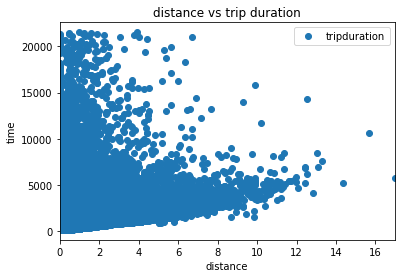

In [15]:
df_2017.plot(x = 'distance', y = 'tripduration', style = 'o')  
plt.title('distance vs trip duration')  
plt.xlabel('distance')  
plt.ylabel('time')  
plt.show()

In [16]:
df_2017['distance'].mean()

1.200548153640619

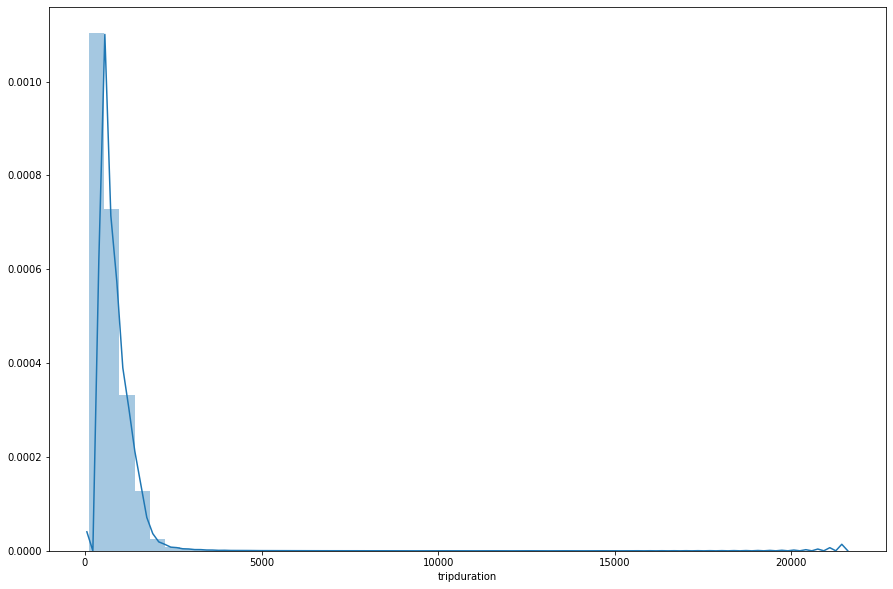

In [17]:
plt.figure(figsize = (15,10))
plt.tight_layout()
sns.distplot(df_2017['tripduration'])

In [18]:
X = df_2017['distance'].values.reshape(-1, 1)
y = df_2017['tripduration'].values.reshape(-1, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [20]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
# intercept
print(regressor.intercept_)
# slope
print(regressor.coef_)

[224.99198436]
[[392.95301322]]


In [22]:
y_pred = regressor.predict(X_test)

In [23]:
df_pred = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred

,Actual,Predicted
0,888,752.098138
1,215,347.998973
2,290,378.163387
3,204,504.154039
4,1155,1292.214890
...,...,...
592150,622,618.968326
592151,1353,774.956630
592152,779,788.688217
592153,434,466.145852


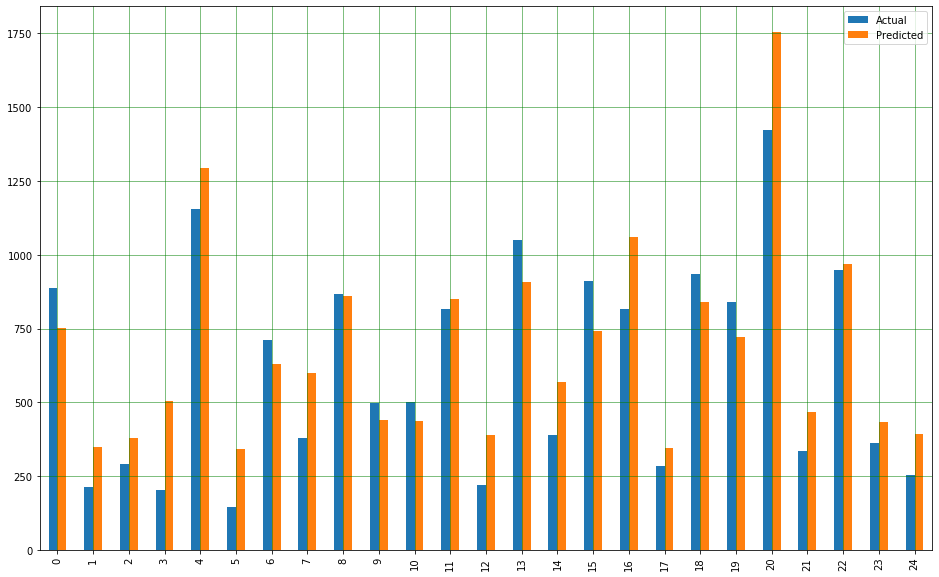

In [24]:
df1 = df_pred.head(25)
df1.plot(kind = 'bar',figsize = (16,10))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.show()

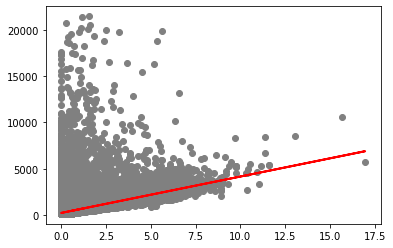

In [25]:
plt.scatter(X_test, y_test,  color = 'gray')
plt.plot(X_test, y_pred, color = 'red', linewidth=2)
plt.show()

In [26]:
# Mean Absolute Error
print(metrics.mean_absolute_error(y_test, y_pred))  
# Mean Squared Error
print(metrics.mean_squared_error(y_test, y_pred))  
# Root Mean Squared Error
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# R^2
print(r2_score(y_test, y_pred))

179.27561068731876
143482.10727096177
378.790320983736
0.457345610354674


## Multiple Linear Regression

In [27]:
X2 = df_2017[['distance', 'Male', 'Subscriber', 'birthyear', 'Customer']]
y2 = df_2017['tripduration']

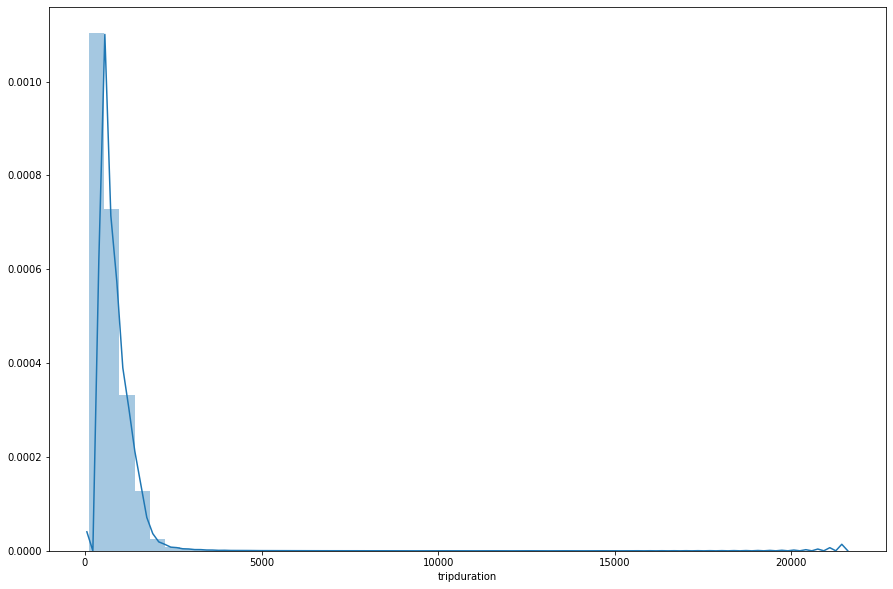

In [28]:
plt.figure(figsize = (15,10))
plt.tight_layout()
sns.distplot(df_2017['tripduration'])

In [29]:
# Split data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state=0)

In [30]:
regressor2 = LinearRegression()  
regressor2.fit(X_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
y_pred2 = regressor2.predict(X_test2)

In [32]:
df_pred2 = pd.DataFrame({'Actual': y_test2, 'Predicted': y_pred2})
df_pred2.head()

,Actual,Predicted
1702299,888,731.111788
913760,215,363.024081
3219051,290,494.226622
1039212,204,469.979824
2084979,1155,1255.310438


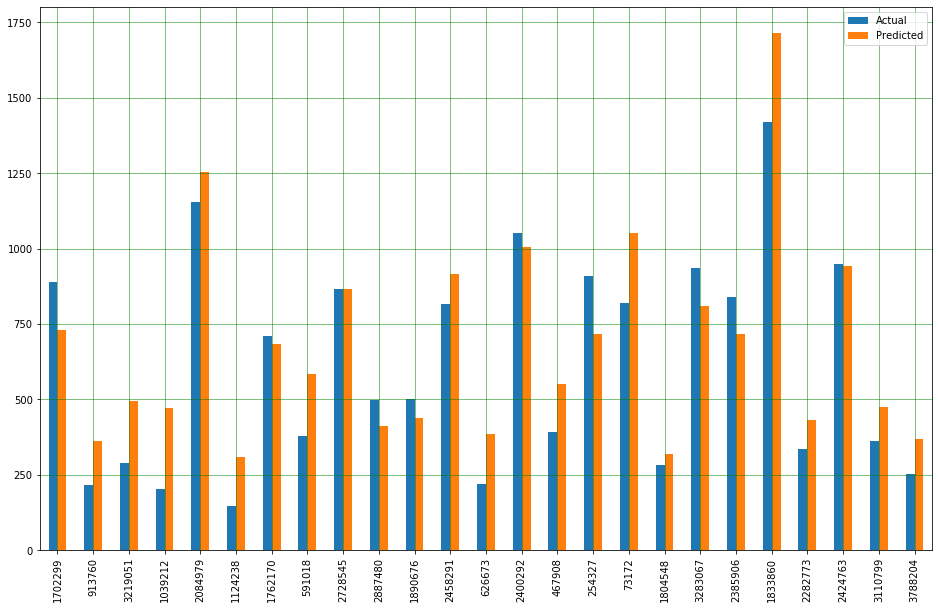

In [33]:
df2 = df_pred2.head(25)
df2.plot(kind = 'bar',figsize = (16, 10))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.show()

In [34]:
# Mean Absolute Error
print(metrics.mean_absolute_error(y_test2, y_pred2)) 
# Mean Squared Error
print(metrics.mean_squared_error(y_test2, y_pred2))  
# Root Mean Squared Error
print(np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))
# R^2
print(r2_score(y_test2, y_pred2))

176.9843190018488
142199.89982309105
377.09401987182326
0.46219496414001393


## Multiple Linear Regression (more variables)

In [35]:
X3 = df_2017[['distance', 'Male', 'birthyear', 'Subscriber', 'Customer', 'from_station_id']]
y3 = df_2017['tripduration']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 0)
regressor3 = LinearRegression()  
regressor3.fit(X_train3, y_train3)
y_pred3 = regressor3.predict(X_test3)

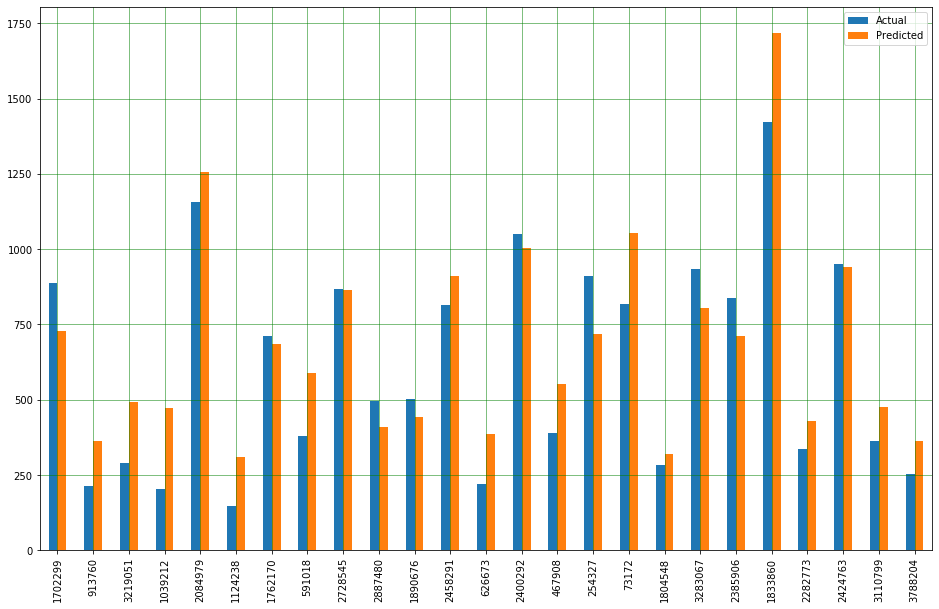

In [36]:
df_pred3 = pd.DataFrame({'Actual': y_test3, 'Predicted': y_pred3})
df_pred3.head()
df3 = df_pred3.head(25)
df3.plot(kind = 'bar',figsize = (16, 10))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.show()

In [37]:
# Mean Absolute Error
print(metrics.mean_absolute_error(y_test3, y_pred3))  
# Mean Squared Error
print(metrics.mean_squared_error(y_test3, y_pred3))  
# Root Mean Squared Error
print(np.sqrt(metrics.mean_squared_error(y_test3, y_pred3)))
# R^2
print(r2_score(y_test3, y_pred3))

176.87591089647734
142193.44996676577
377.08546772153096
0.4622193577240925


In [38]:
# Clean data more
# drop rides greater than 4 hours
df_2017_b = df_2017[df_2017.tripduration < 14400]

In [39]:
X4 = df_2017_b[['distance', 'Male', 'Subscriber', 'birthyear', 'Customer']]
y4 = df_2017_b['tripduration']
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size = 0.2, random_state = 0)
regressor4 = LinearRegression()  
regressor4.fit(X_train4, y_train4)
y_pred4 = regressor4.predict(X_test4)


In [40]:
# # Mean Absolute EError
# print(metrics.mean_absolute_error(y_test, y_pred))  
# # Mean Squared Error
# print(metrics.mean_squared_error(y_test, y_pred))  
# # Root Mean Squared Error
# print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# # R^2
# print(r2_score(y_test, y_pred))

In [41]:
# Clean even more
# drop rides greater 3 hours
df_2017_c = df_2017[df_2017.tripduration < 10800]
X5 = df_2017_c[['distance', 'Male', 'Subscriber', 'birthyear', 'Customer']]
y5 = df_2017_c['tripduration']
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size = 0.2, random_state = 0)
regressor5 = LinearRegression()  
regressor5.fit(X_train5, y_train5)
y_pred5 = regressor5.predict(X_test5)
print(metrics.mean_absolute_error(y_test5, y_pred5))  
print(r2_score(y_test5, y_pred5))

173.50785045601452
0.5370370952188395


In [42]:
# Clean even more
# drop rides greater 2 hours
df_2017_d = df_2017[df_2017.tripduration < 7200]
# drop rides greater further than 10 miles
df_2017_e = df_2017_d[df_2017.distance < 20]
X6 = df_2017_e[['distance', 'Male', 'Subscriber', 'birthyear', 'Customer']]
y6 = df_2017_e['tripduration']
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size = 0.2, random_state = 0)
regressor6 = LinearRegression()  
regressor6.fit(X_train6, y_train6)
y_pred6 = regressor6.predict(X_test6)
print(metrics.mean_absolute_error(y_test6, y_pred6)) 
print(r2_score(y_test6, y_pred6))

/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


171.62421450116273
0.57017459378753


## Ridge

In [43]:
df_f = df_2017[['trip_id', 'bikeid', 'tripduration', 'birthyear', 'from_lat','from_long', 'to_lat', 'to_long', 'distance', 'speed']]
y7 = df_f.tripduration
X7 = df_f.drop(['tripduration'], axis = 1).astype(float)
X7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2960771 entries, 0 to 3829000
Data columns (total 9 columns):
trip_id      float64
bikeid       float64
birthyear    float64
from_lat     float64
from_long    float64
to_lat       float64
to_long      float64
distance     float64
speed        float64
dtypes: float64(9)
memory usage: 305.9 MB


In [44]:
alphas = 10**np.linspace(10 ,-2, 100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [45]:
ridge = Ridge(normalize = True)
coefs = []
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X7, y7)
    coefs.append(ridge.coef_)
np.shape(coefs)

(100, 9)

Text(0, 0.5, 'weights')

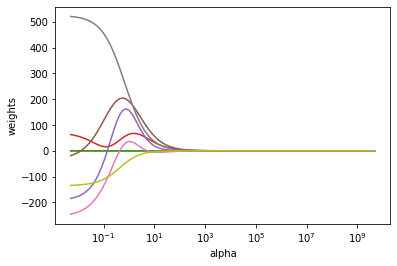

In [46]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [47]:
X_train7, X_test7 , y_train7, y_test7 = train_test_split(X, y, test_size = 0.5, random_state = 1)
ridge7 = Ridge(alpha = 1, normalize = True)
ridge7.fit(X_train7, y_train7)             
pred7 = ridge7.predict(X_test7)           
# print(pd.Series(ridge7.coef_, index = X7.columns)) 
# print(mean_squared_error(y_test7, pred7))     
# R^2
# Ridge.score(ridge7, X, y)

In [48]:
# find alpha that results in smallest cross validation
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train7, y_train7)
ridgecv.alpha_

0.005

In [49]:
# rr with alpha that minimizes cross validation
ridge8 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge8.fit(X_train7, y_train7)
pred8 = ridge8.predict(X_test7)  
# MSE
mean_squared_error(y_test7, ridge8.predict(X_test7))
ridge8.fit(X7, y7)
pd.Series(ridge8.coef_, index = X7.columns)
#R^2
Ridge.score(ridge8, X7, y7)

0.6686093217995586

## Lasso

Text(0, 0.5, 'weights')

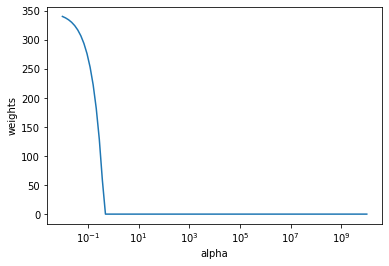

In [50]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [51]:
# lasso 10 fold cross validation
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha = lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test)) 
# #R^2 
# Lasso.score(lassocv, X, y)

/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


143482.27501047813

In [52]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train2), y_train2)
    coefs.append(lasso.coef_)
# ax = plt.gca()
# ax.plot(alphas*2, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('weights')
# lasso 10 fold cross validation
lassocv2 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv2.fit(X_train2, y_train2)
lasso.set_params(alpha = lassocv2.alpha_)
lasso.fit(X_train2, y_train2)
mean_squared_error(y_test2, lasso.predict(X_test2)) 
Lasso.score(lassocv2, X2, y2)

0.45751604729402906

In [53]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train3), y_train3)
    coefs.append(lasso.coef_)
# ax = plt.gca()
# ax.plot(alphas*3, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('weights')
# lasso 10 fold cross validation
lassocv3 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv3.fit(X_train3, y_train3)
lasso.set_params(alpha = lassocv3.alpha_)
lasso.fit(X_train3, y_train3)
mean_squared_error(y_test3, lasso.predict(X_test3)) 
Lasso.score(lassocv3, X3, y3)

0.4575400526724601

In [54]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train4), y_train4)
    coefs.append(lasso.coef_)
# ax = plt.gca()
# ax.plot(alphas*4, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('weights')
# lasso 10 fold cross validation
lassocv4 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv4.fit(X_train4, y_train4)
lasso.set_params(alpha = lassocv4.alpha_)
lasso.fit(X_train4, y_train4)
mean_squared_error(y_test4, lasso.predict(X_test4)) 
Lasso.score(lassocv4, X4, y4)

0.5016271651689078

In [55]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train5), y_train5)
    coefs.append(lasso.coef_)
# ax = plt.gca()
# ax.plot(alphas*5, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('weights')
# lasso 10 fold cross validation
lassocv5 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv5.fit(X_train5, y_train5)
lasso.set_params(alpha = lassocv5.alpha_)
lasso.fit(X_train5, y_train5)
mean_squared_error(y_test5, lasso.predict(X_test5)) 
Lasso.score(lassocv5, X5, y5)

0.5316741090076817

In [56]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train6), y_train6)
    coefs.append(lasso.coef_)
# ax = plt.gca()
# ax.plot(alphas*6, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('weights')
# lasso 10 fold cross validation
lassocv6 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv6.fit(X_train6, y_train6)
lasso.set_params(alpha = lassocv6.alpha_)
lasso.fit(X_train6, y_train6)
mean_squared_error(y_test6, lasso.predict(X_test6)) 
Lasso.score(lassocv6, X6, y6)

0.5674277161717671

In [57]:
# lasso = Lasso(max_iter = 10000, normalize = True)
# coefs = []
# for a in alphas:
#     lasso.set_params(alpha = a)
#     lasso.fit(scale(X_train7), y_train7)
#     coefs.append(lasso.coef_)
# # ax = plt.gca()
# # ax.plot(alphas*7, coefs)
# # ax.set_xscale('log')
# # plt.axis('tight')
# # plt.xlabel('alpha')
# # plt.ylabel('weights')
# # lasso 10 fold cross validation
# lassocv7 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
# lassocv7.fit(X_train7, y_train7)
# lasso.set_params(alpha = lassocv7.alpha_)
# lasso.fit(X_train7, y_train7)
# mean_squared_error(y_test7, lasso.predict(X_test7)) 
# Lasso.score(lassocv7, X7, y7)

## Best Model

In [58]:
# df_2017 = df_2017[df_2017.tripduration < 10800]
# df_2017 = df_2017[df_2017.distance < 20]
df = df_2017_e[['trip_id', 'bikeid', 'tripduration', 'birthyear', 'from_lat','from_long', 'to_lat', 'to_long', 'distance', 'speed']]
y9 = df.tripduration
X9 = df.drop(['tripduration'], axis = 1).astype(float)
X9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2959547 entries, 0 to 3829000
Data columns (total 9 columns):
trip_id      float64
bikeid       float64
birthyear    float64
from_lat     float64
from_long    float64
to_lat       float64
to_long      float64
distance     float64
speed        float64
dtypes: float64(9)
memory usage: 225.8 MB


Text(0, 0.5, 'weights')

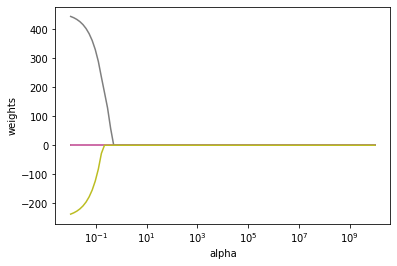

In [59]:
X_train9, X_test9 , y_train9, y_test9 = train_test_split(X9, y9, test_size = 0.2, random_state = 1)
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train9), y_train9)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [60]:
# lasso 10 fold cross validation
lassocv9 = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv9.fit(X_train9, y_train9)
lasso.set_params(alpha = lassocv.alpha_)
lasso.fit(X_train9, y_train9)
print(mean_squared_error(y_train9, lasso.predict(X_train9)))
print(mean_squared_error(y_test9, lasso.predict(X_test9)))
print(mean_squared_error(y_train9, lasso.predict(X_train9))**.5)
print(mean_squared_error(y_test9, lasso.predict(X_test9))**.5)

42901.90389858489
44036.39488668962
207.12774777558147
209.84850460913373


In [61]:
#R^2 
Lasso.score(lassocv9, X9, y9)

0.7992729770818422